<a href="https://colab.research.google.com/github/hinton024/Assignment-2-Social-media-and-network-analytics/blob/main/Reddit_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download necessary libraries

In [5]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.6 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=f7e74915544049454b31803aad7a8f23e528977adffcdc2fe8dd0579d2e5c7b3
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


### Importing the Necessary Libraries

In [6]:
import pandas as pd
import re
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import nltk
from langdetect import detect, LangDetectException
import contractions
from collections import Counter

### 1. Data Preprocessing
#### Loading the Data

In [7]:
# List of NLTK data packages to download
nltk_packages = ['punkt', 'wordnet', 'stopwords']

# Download each package
for package in nltk_packages:
    nltk.download(package)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
with open('DB_reddit.json', 'r', encoding='utf-8') as file:
    reddit = json.load(file)

# Converting the data into a DataFrame
df = pd.DataFrame(reddit)
df.head()

,title,score,date,url,num_comments,comments
0,Not under David Beckhams watch,65534,2023-10-06 17:16:05,https://v.redd.it/0mmzjpgdyisb1,2042,"[Please report rule breaking posts, such as:\n..."
1,David Beckham is not letting this go...,29482,2024-01-02 14:44:45,https://i.redd.it/dowdawvo7y9c1.jpeg,982,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
2,David and Victoria Beckham finally addressing ...,800,2023-10-05 20:46:41,https://v.redd.it/ahnysog1vcsb1,261,[I think if they hadn’t brought this up in a d...
3,Victoria Beckham shares photo of husband David...,2687,2023-12-16 10:45:59,https://i.redd.it/nd35a08lpj6c1.jpeg,298,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
4,Micah Richards on David Beckham,5650,2024-09-19 18:27:36,https://v.redd.it/7o6n7df28qpd1,256,[**Mirrors / Alternative Angles**\n \n\n*I am...


#### Check for Missing Values

In [9]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()

# Display missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
title           0
score           0
date            0
url             0
num_comments    0
comments        0
dtype: int64


#### Check for Duplicate Values

In [10]:
duplicates = df.duplicated(subset=['url']).sum()
print(f"Number of duplicate rows: {duplicates}")
df.drop_duplicates(subset=['url'], inplace=True)

Number of duplicate rows: 0


#### Advance Preprocessing

In [11]:
# Regular expression pattern for detecting URLs
url_pattern = r'http\S+|www\S+|https\S+'

# Function to check for URLs in text
def contains_url(text):
    return bool(re.search(url_pattern, text))

# Check for URLs in the 'title' column
df['Title_Contains_URL'] = df['title'].apply(contains_url)

# Check for URLs in the 'comments' column (handling multiple comments in each row)
df['Comments_Contain_URL'] = df['comments'].apply(lambda comments: any(contains_url(comment) for comment in comments))

# Display rows where URLs are found in either title or comments
urls_in_data = df[(df['Title_Contains_URL']) | (df['Comments_Contain_URL'])]

# Display the results
print(f"Total rows with URLs in title: {df['Title_Contains_URL'].sum()}")
print(f"Total rows with URLs in comments: {df['Comments_Contain_URL'].sum()}")

# Optionally, display the rows that contain URLs
if not urls_in_data.empty:
    print("\nRows containing URLs:")
    print(urls_in_data[['title', 'comments']].head())
else:
    print("\nNo URLs found in the dataset.")

Total rows with URLs in title: 0
Total rows with URLs in comments: 81

Rows containing URLs:
                                               title  \
0                     Not under David Beckhams watch   
1            David Beckham is not letting this go...   
2  David and Victoria Beckham finally addressing ...   
3  Victoria Beckham shares photo of husband David...   
4                    Micah Richards on David Beckham   

                                            comments  
0  [Please report rule breaking posts, such as:\n...  
1  [Welcome to r/popculturechat! ☺️\n\nAs a proud...  
2  [I think if they hadn’t brought this up in a d...  
3  [Welcome to r/popculturechat! ☺️\n\nAs a proud...  
4  [**Mirrors / Alternative Angles**\n  \n\n*I am...  


In [12]:
# Function to clean text (already removing URLs)
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9'\s]", '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Reapply the cleaning function to comments with URLs
df['Cleaned_Comments'] = df['comments'].apply(lambda comments: [clean_text(comment) for comment in comments])

# Verify the removal of URLs by checking the updated comments
urls_in_comments_after_removal = df['Cleaned_Comments'].apply(lambda comments: any(re.search(url_pattern, comment) for comment in comments)).sum()
print(f"Total rows with URLs in comments after removal: {urls_in_comments_after_removal}")


# Function to detect if the text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

Total rows with URLs in comments after removal: 0


In [13]:
# Cleaning and preprocess titles
df['Cleaned_Title'] = df['title'].apply(lambda x: expand_contractions(clean_text(str(x))) if is_english(str(x)) else '')

# Preprocessing each comment within the list
df['Cleaned_Comments'] = df['comments'].apply(lambda comments: [expand_contractions(clean_text(comment)) for comment in comments if is_english(comment)])

#### Stopwords Removal

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_tokens(tokens):
    # Remove stopwords and lemmatize
    tokens = [word for word in tokens if word not in stop_words]
    # If no tokens are left after stopword removal, return the original tokens
    if not tokens:
        return tokens
    return [lemmatizer.lemmatize(word) for word in tokens]

#### Tokenization and Lemmatization

In [15]:
# Tokenize and lemmatize the cleaned text
df['Title_Tokens'] = df['Cleaned_Title'].apply(lambda x: process_tokens(word_tokenize(x)))
df['Comments_Tokens'] = df['Cleaned_Comments'].apply(lambda comments: [process_tokens(word_tokenize(comment)) for comment in comments])

In [16]:
# Display the processed data
processed_columns = ['title', 'Cleaned_Title', 'Title_Tokens', 'comments', 'Cleaned_Comments', 'Comments_Tokens']
print("\nProcessed Data:")
print(df[processed_columns].head(10))


Processed Data:
                                               title  \
0                     Not under David Beckhams watch   
1            David Beckham is not letting this go...   
2  David and Victoria Beckham finally addressing ...   
3  Victoria Beckham shares photo of husband David...   
4                    Micah Richards on David Beckham   
5                                Young David Beckham   
6                         Thoughts on David Beckham?   
7  david beckham: then vs now – is it just me or ...   
8                          David Beckham is autistic   
9  David and Victoria Beckham recreate their wedd...   

                                       Cleaned_Title  \
0                                                      
1               david beckham is not letting this go   
2  david and victoria beckham finally addressing ...   
3  victoria beckham shares photo of husband david...   
4                    micah richards on david beckham   
5                             

#### Term Frequency

In [17]:
lemmatizer = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))

def process_text(text, lemmatizer, stopwords_set):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_set]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

term_freq_counter = Counter()

# Processing each row in the DataFrame and updating term frequency counts
for _, row in df.iterrows():
    tokens_title = process_text(row['Cleaned_Title'], lemmatizer, stopwords_set)
    tokens_comments = [word for comment in row['Cleaned_Comments'] for word in process_text(comment, lemmatizer, stopwords_set)]

    # Updating term frequency counts
    term_freq_counter.update(tokens_title)
    term_freq_counter.update(tokens_comments)

# Displaying the most common terms
freq_num = 50
print(f"Top {freq_num} most common terms:")
for term, count in term_freq_counter.most_common(freq_num):
    print(f"{term}: {count}")

Top 50 most common terms:
like: 2634
would: 1825
people: 1739
think: 1395
one: 1357
know: 1190
look: 1127
class: 1110
get: 1089
beckham: 1075
time: 1000
really: 912
even: 912
david: 852
good: 842
also: 823
make: 806
year: 799
thing: 780
much: 772
love: 720
still: 702
way: 696
's: 680
never: 671
could: 670
see: 622
working: 618
well: 613
going: 605
money: 598
say: 578
always: 564
lol: 562
got: 559
go: 549
lot: 543
want: 530
right: 516
victoria: 512
work: 510
someone: 507
mean: 506
u: 503
woman: 467
man: 459
said: 458
back: 455
made: 446
though: 444


# WordCloud of Sentiment Heavy Words and Entities

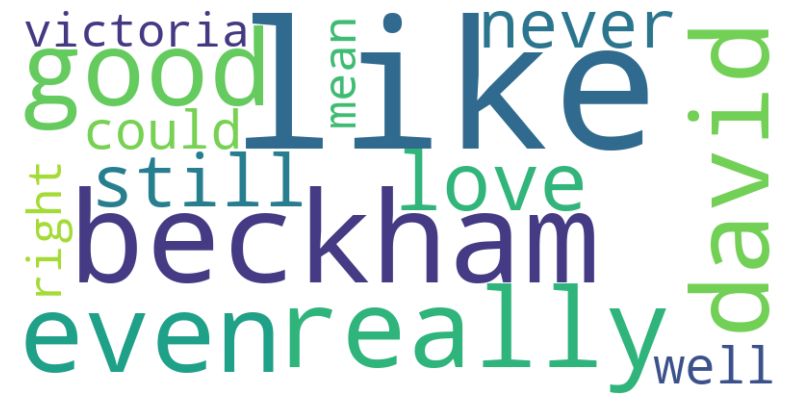

In [18]:
# Visualizing the sentiment heavy words and entities by WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Dictionary with sentiment heavy words and entities and their frequencies as values
words_freq = {
    "like": 2627,
    "beckham": 1077,
    "really": 912,
    "even": 911,
    "good": 844,
    "david": 848,
    "love": 720,
    "still": 702,
    "never": 671,
    "could": 669,
    "well": 614,
    "right": 517,
    "victoria": 512,
    "mean": 504
}


# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_freq)

# Plotting the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hiding axes
plt.show()


# Bar Chart of Sentiment Heavy Words and Entities with their frequencies

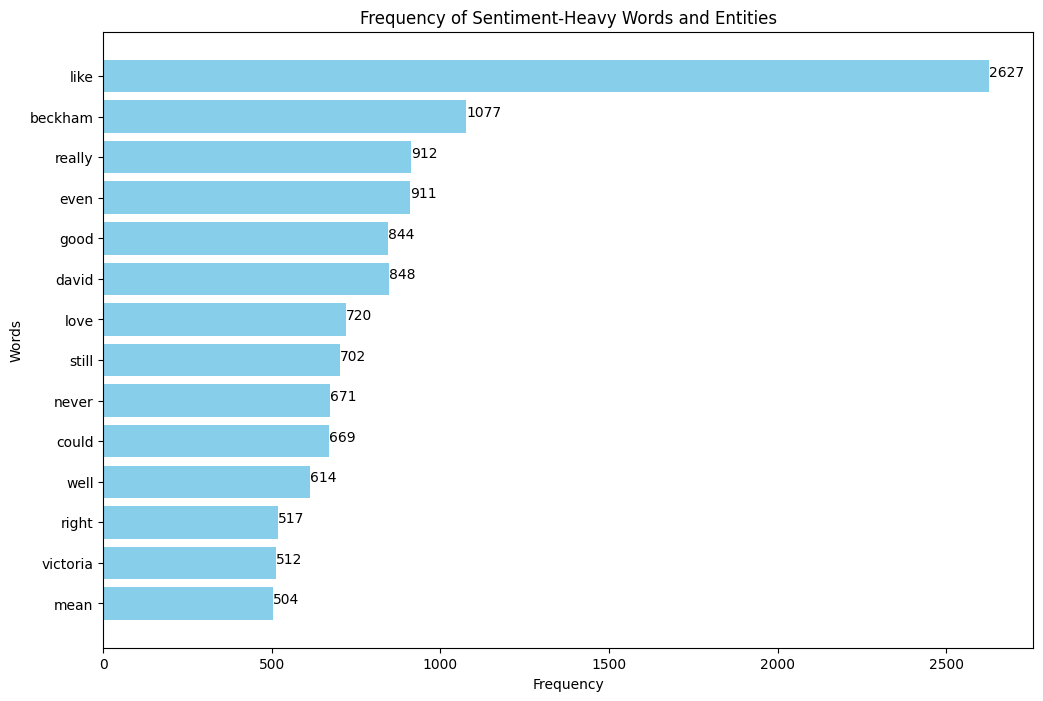

In [19]:
# Visualizing the sentiment heavy words and entities and their frequencies as values

# List of words and their frequencies
words = [
    'like', 'beckham', 'really', 'even', 'good', 'david', 'love',
    'still', 'never', 'could', 'well', 'right', 'victoria', 'mean'
]

frequencies = [
    2627, 1077, 912, 911, 844, 848, 720,
    702, 671, 669, 614, 517, 512, 504
]


# Plotting the bar chart
plt.figure(figsize=(12,8))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Frequency of Sentiment-Heavy Words and Entities')
plt.gca().invert_yaxis()  # Inverting y axis to have the most frequent word on top

# Adding frequencies next to the bars  # Adding frequencies next to the bar
for index, value in enumerate(frequencies):
    plt.text(value, index, str(value))
plt.show()


# Tfidf Vectorization

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function for Pre-processing text by removing numbers
def preprocess_text(text):
    return re.sub(r'\d+', '', text)

# loading data from json file
with open('DB_reddit.json', 'r', encoding='utf-8') as f:
    posts_data = json.load(f)

    comments = []
    for post in posts_data:
        for comment in post['comments']:
            preprocessed_comment = preprocess_text(comment)  # Preprocessing the comments
            comments.append(preprocessed_comment)  # Storing preprocessed comments

# Converting the comments into a dataframe
df = pd.DataFrame(comments, columns=['Cleaned_Comments'])

# Checking the dataframe
print("DataFrame preview (first 5 rows):")
print(df.head())

# Adjusting the token pattern to exclude purely numerical tokens and refining the ngram range
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b',  # Excludes purely numeric tokens and requires at least three characters
    ngram_range=(1,2),  #unigram and bi-gram
    min_df=10,  # Increase min_df to reduce features that appear rarely
    max_df=0.5 # Lower max_df to exclude terms that are too common

)

# Fitting and transforming the comments into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Comments']).toarray()

# Converting to DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())

DataFrame preview (first 5 rows):
                                    Cleaned_Comments
0  Please report rule breaking posts, such as:\n\...
1                         David ain't fuckin' around
2  David Beckham actually grew up working class s...
3           Well, she wasn’t Poor Spice for a reason
4  David Beckham is pissed because he is actually...
   ability  able  absolute  absolutely     abuse  accent   account  act  \
0      0.0   0.0       0.0         0.0  0.312261     0.0  0.152936  0.0   
1      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
2      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
3      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   
4      0.0   0.0       0.0         0.0  0.000000     0.0  0.000000  0.0   

   acting   action  ...  year old  years  years ago  yep  yes  young  younger  \
0     0.0  0.13697  ...       0.0    0.0        0.0  0.0  0.0    0.0      0.0   
1     0.0  0.00000  ...       0.0  

# Vader Sentiment Analysis

In [21]:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initializing VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis with error handling
def analyze_sentiment(text):
    if text:  # Checking if text is not empty or None
        try:
            sentiment = analyzer.polarity_scores(text)
            return sentiment['compound']  # Compund score represents overall sentiment
        except Exception as e:
            print(f"Error analyzing sentiment: {e}")
            return None  # Return None if there's an error
    else:
        return None  # Return None for empty or None text

# Applying sentiment analysis
df['sentiment_score'] = df['Cleaned_Comments'].apply(analyze_sentiment)

# Categorize sentiment based on the score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# Printing results
print("DataFrame with sentiment scores and categories (first 5 rows):")
print(df[['Cleaned_Comments', 'sentiment_score', 'sentiment_category']].head())

DataFrame with sentiment scores and categories (first 5 rows):
                                    Cleaned_Comments  sentiment_score  \
0  Please report rule breaking posts, such as:\n\...          -0.9505   
1                         David ain't fuckin' around           0.0000   
2  David Beckham actually grew up working class s...           0.0000   
3           Well, she wasn’t Poor Spice for a reason          -0.2500   
4  David Beckham is pissed because he is actually...          -0.6369   

  sentiment_category  
0           negative  
1            neutral  
2            neutral  
3           negative  
4           negative  


# Visualizing sentiment score distribution by histogram and density plot

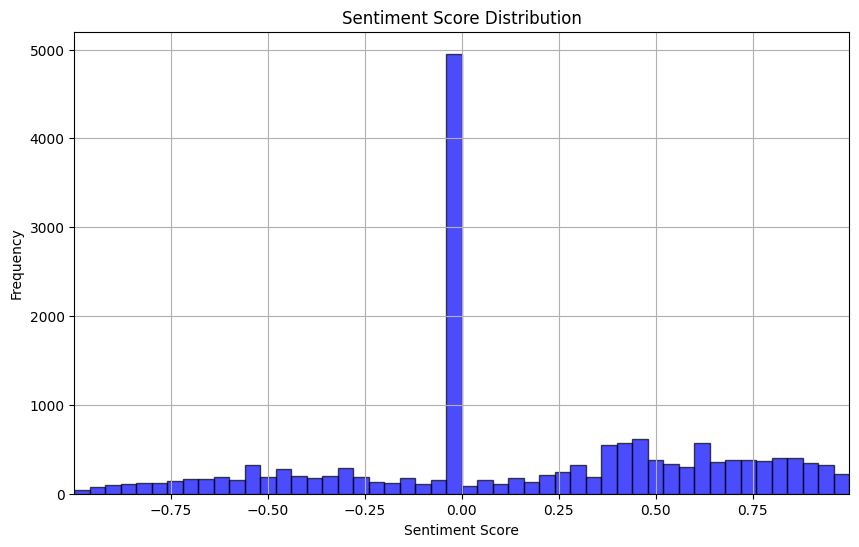

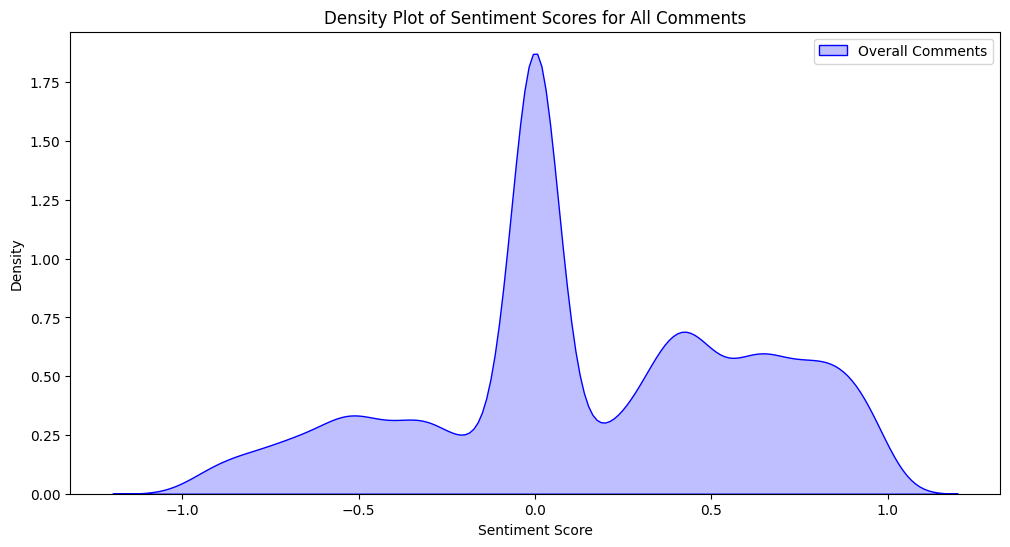

In [22]:
#Visualizing sentiment score distribution by histogram and density plot

num_bins = 50  # Number of bins

# Plotting sentiment score distribution
plt.figure(figsize=(10,6))
plt.hist(df['sentiment_score'], bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
plt.grid(True)   # For better readability

# Setting plot titles and labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')

# Setting x and y limits
plt.xlim(df['sentiment_score'].min(), df['sentiment_score'].max())
plt.ylim(0, plt.ylim()[1])  # Ensuring y axis starts from 0 and is correclty scaled

plt.show()


# Plotting density of sentiment scores for all comments
import seaborn as sns
plt.figure(figsize=(12,6))
sns.kdeplot(df['sentiment_score'], fill=True, color='blue', label='Overall Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores for All Comments')
plt.legend()
plt.show()

# Word Cloud for overall comments

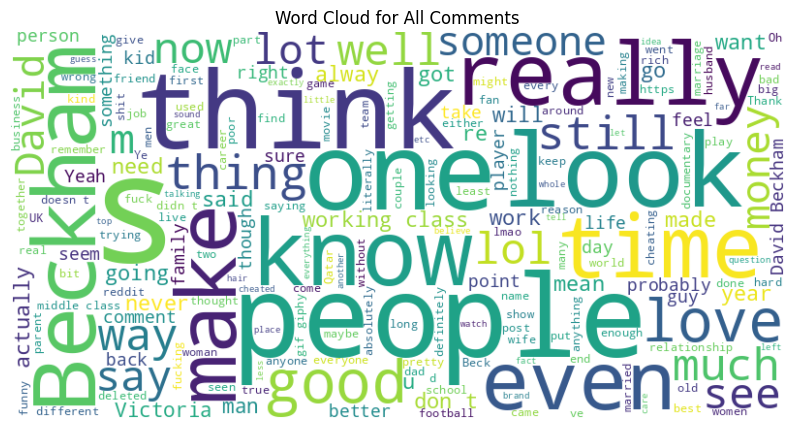

In [23]:
# Word Cloud for overall comments

from wordcloud import WordCloud, STOPWORDS
all_comments = ' '.join(df['Cleaned_Comments'])

# Generating word cloud with custom settings
wordcloud = WordCloud(
    width=800, height=400, background_color='white',
    stopwords=set(STOPWORDS), max_words=200, colormap='viridis'
).generate(all_comments)

# Displaying the word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels and ticks
plt.title('Word Cloud for All Comments')
plt.show()


## Topic Modelling

### Plotting coherence term plot to determine optimal number of topics

In [24]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import numpy as np
# Extracting 'Cleaned_Comments' from the DataFrame
lPosts = df['Cleaned_Comments'].tolist()
data = [post.split() for post in lPosts]

# Create Dictionary and Corpus (this part remains the same)
id2word = corpora.Dictionary(data)
texts = data
corpus = [id2word.doc2bow(text) for text in texts]

# def compute_coherence_for_model(params):
#     """Compute coherence for a single model"""
#     num_topics, dictionary, corpus, texts = params
#     model = gensim.models.LdaModel(
#         corpus=corpus,
#         id2word=dictionary,
#         num_topics=num_topics,
#         random_state=100,
#         update_every=1,
#         chunksize=100,
#         passes=10,
#         alpha='auto',
#         per_word_topics=True
#     )
#     coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#     return coherence_model.get_coherence()

# def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
#     """Compute coherence values for multiple models in parallel"""
#     pool = Pool(processes=cpu_count())
#     coherence_values = pool.map(
#         compute_coherence_for_model,
#         [(num_topics, dictionary, corpus, texts) for num_topics in range(start, limit, step)]
#     )
#     pool.close()
#     pool.join()
#     return coherence_values

# # Set parameters
# start, limit, step = 2, 40, 6

# # Compute coherence values
# coherence_values = compute_coherence_values(id2word, corpus, texts, start, limit, step)

# # Plot results
# x = range(start, limit, step)
# plt.figure(figsize=(12, 6))
# plt.plot(x, coherence_values, 'bo-')
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score")
# plt.title("Topic Coherence Scores by Number of Topics")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Find optimal number of topics
# optimal_num_topics = x[np.argmax(coherence_values)]
# print(f'Optimal number of topics: {optimal_num_topics}')


In [25]:
topicNum = 5
wordNumToDisplay = 10
featureNum = 1500

## Performs counting via CountVectorizer and then apply the LDA model.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lPosts)
tfFeatureNames = tfVectorizer.get_feature_names_out()

ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

### Visualising topics

In [27]:
# Define the display_topics function
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        for i in topic.argsort()[:-num_top_words - 1:-1]:
            print(f"{feature_names[i]} ({topic[i]:.4f})")
        print()

## Diplays discovered topics.

In [28]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
class (895.7867)
working (523.6063)
going (449.7997)
david (399.8392)
beckham (337.9913)
maybe (313.0882)
great (303.2371)
yes (280.0353)
old (271.2701)
middle (266.4244)

Topic 1:
don (1101.9914)
people (1041.7966)
just (1021.1034)
think (865.6425)
time (850.9544)
really (725.2788)
like (695.4116)
know (581.0178)
did (490.2525)
want (421.6739)

Topic 2:
just (681.0573)
like (627.6067)
right (499.3309)
love (470.2475)
people (432.5667)
good (401.8294)
yeah (385.3210)
think (382.7318)
way (382.0104)
pretty (350.2909)

Topic 3:
like (1111.9507)
look (637.0826)
https (626.0914)
looks (572.4826)
said (463.2462)
does (369.8400)
com (322.9465)
bad (260.9679)
www (257.9934)
reddit (257.2453)

Topic 4:
beckham (616.4394)
man (511.5684)
years (507.7939)
didn (398.9846)
got (386.1066)
football (371.4326)
world (360.2215)
thought (338.8305)
best (322.0927)
remember (284.3576)



In [29]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne') # Use lda_model for prepare
pyLDAvis.display(panel)

# Network Analysis and Community Detection

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Documents related to Topic 0:

Document 1: David ain't fuckin' around

Document 2: David Beckham actually grew up working class so he knows what it means to be working class.

Document 3: David Beckham is pissed because he is actually from the working class.

Document 4: A fucking rolls Royce hahahaha go on David lad still down to earth even though he’s a millionaire and his missus is a dick

Document 5:  years of marriage, yes you start calling each other out for their bullshit.

Document 6: If this show is just David calling her out on bullshit then I might sail that sea.

Document 7: Becks grew up working class, so maybe she's stealing his stories for clout.

Document 8: He took that shit personal.

There's only one person that grew up working class in that house and it ain't her.

Document 9: God bless David Beckham
😆

Document 10: Great ad

Document 11: Netflix is a pile of shit

Document 12: Guys, this was in the trailer. This was clearly staged and edited to get the most attenti

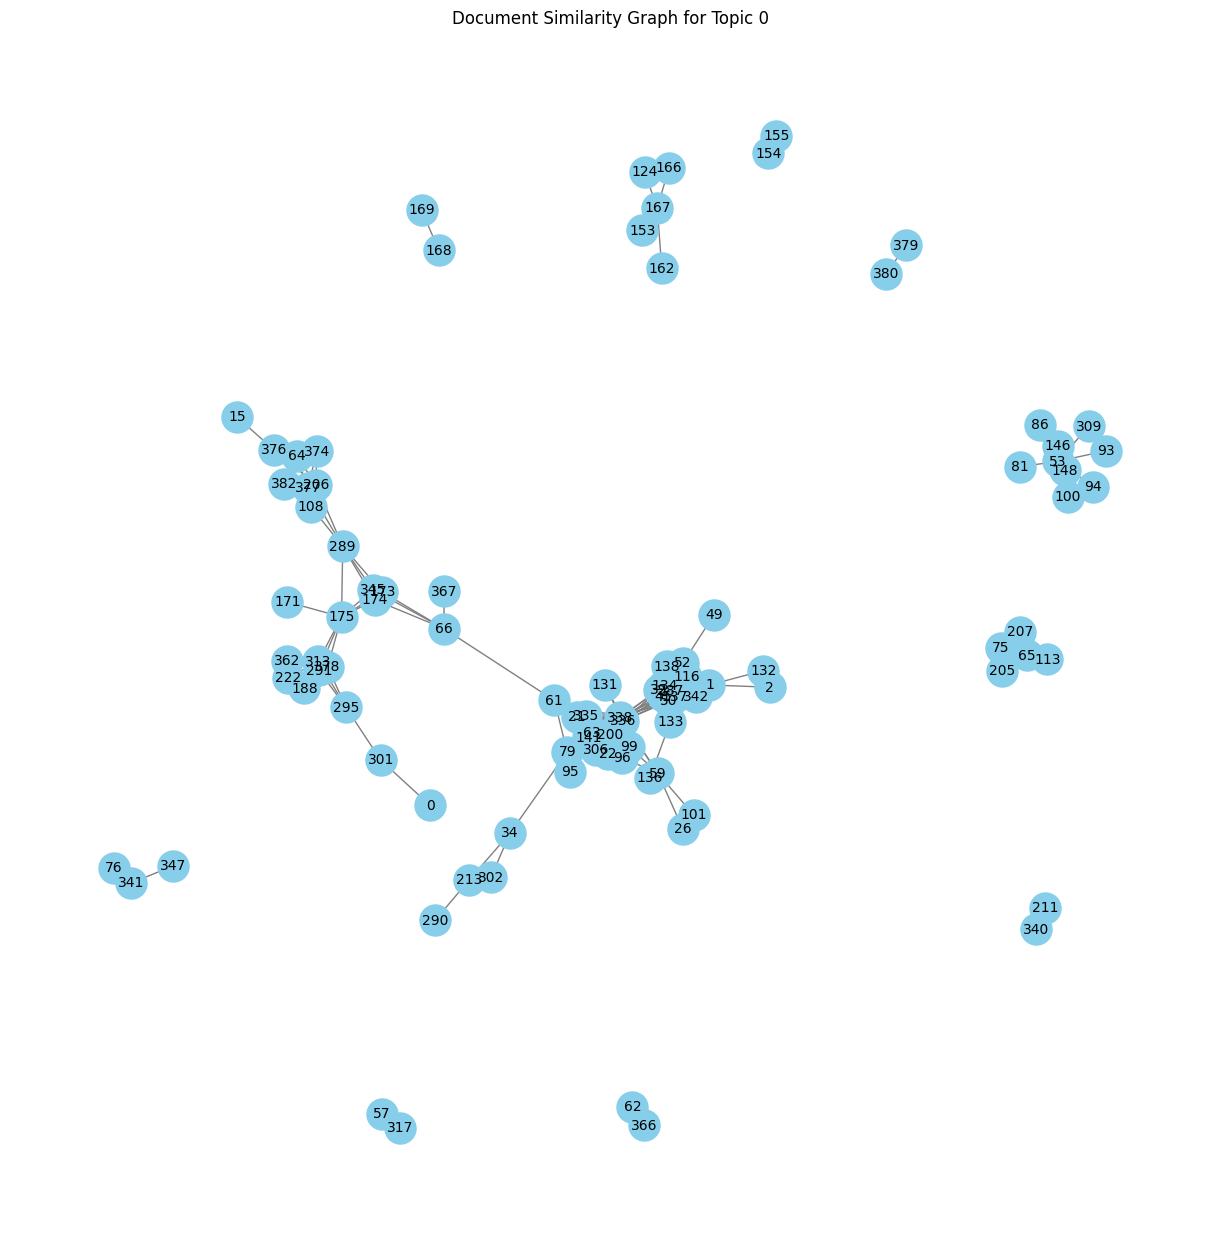

Documents related to Topic 1:

Document 1: The door shutting at the end sums it all up. I guess Beckham really knows how to handle a ball and also a dumb clueless chick.

Document 2: This is gold lmao.

Document 3: Why so rich people have this impulse to show they come from humble beginnings or that they worked hard to make their way to the top…  if you were born rich, so what?

Document 4: Kim Kardashian is the worst. She’s telling people to work hard when she wh*red herself out for fame.

Document 5: That voice on him is a boner killer tho...

Document 6: Wasn’t she “posh spice” of the spice girls? lmfao

Document 7: Why is she so desperate to pretend like she wasn’t always wealthy?

Document 8:  Thank you. Watching now!

Document 9: Not that night, at least. Couch time.

Document 10: Definitely not later. That’s also for sure 😅

Document 11: I mean she was never posh. She was what girls in council estates would consider posh. She was new money.

Document 12: she doesn't want people 

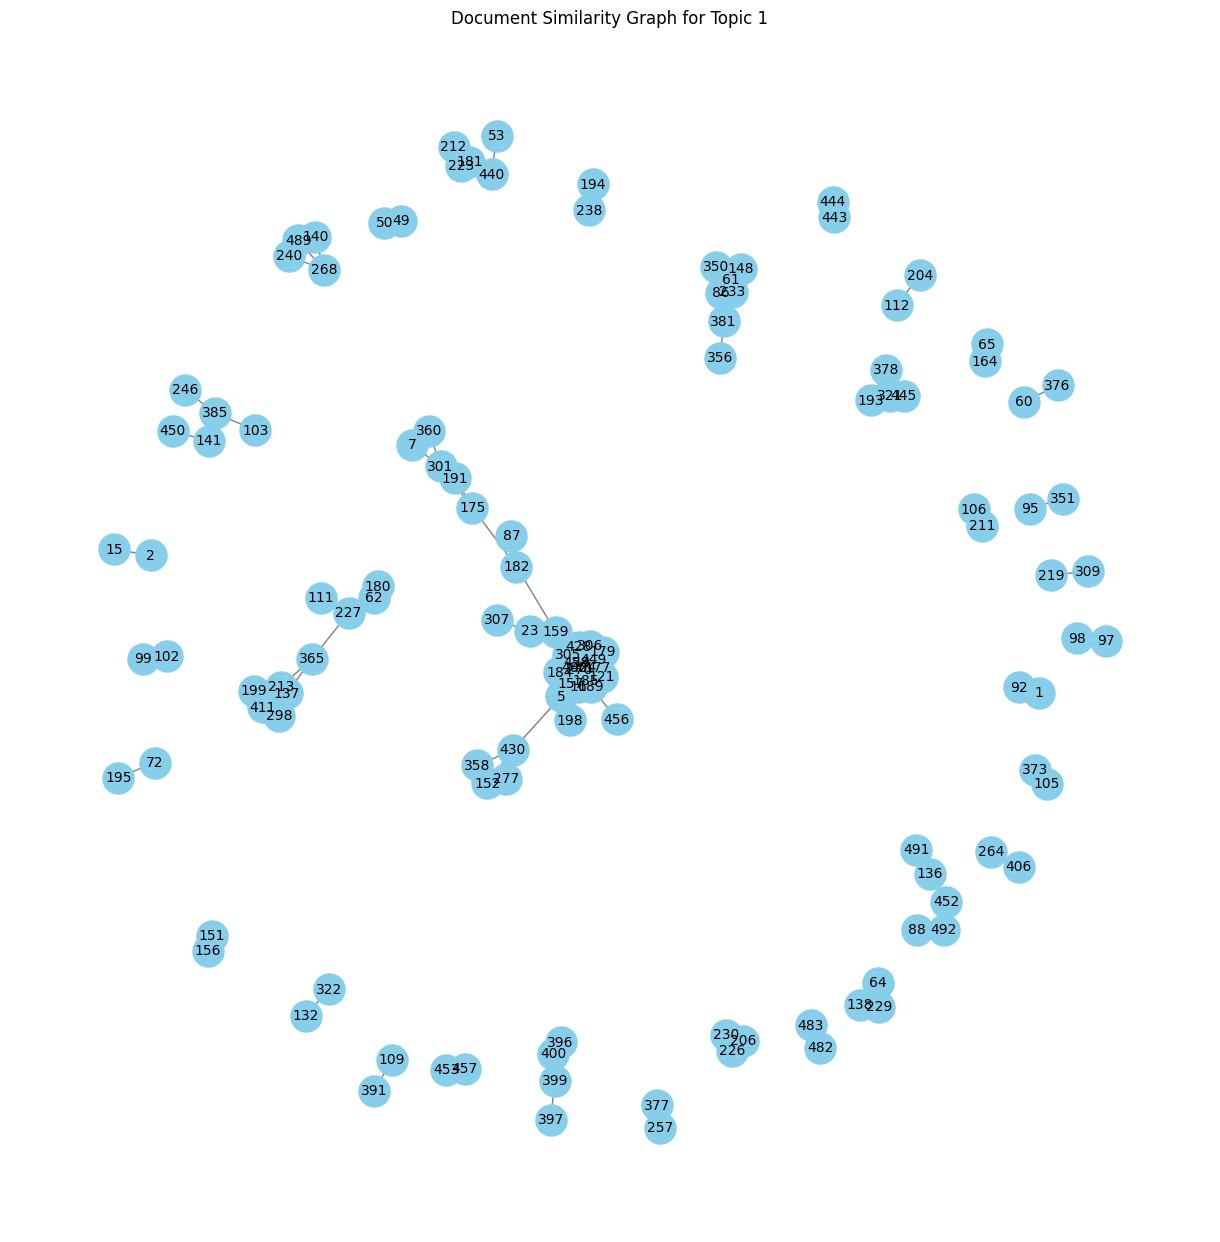

Documents related to Topic 2:

Document 1: The way that she gives that smug smile at the end makes the whole thing seem even more performative

Document 2: This is good marketing for their tv series.

Document 3: You know what, I respect this dynamic in a marriage. Calling each others white lies out and Victoria being full aware she is fibbing but not getting overly offended. Must be a British thing. They get it

Document 4: Some people think working class just means having a job and not just being a socialite or big celebrity

Document 5: I love how he called her out 😅

Document 6: Little smirk at the end, followed up by a sniff to clear out the last of the morning coke…

Document 7: Dude could have any woman on the planet and he married this mid-tier annoying chick? She must be absolutely mind-blowing in bed!!

Document 8: Yeah, I swear some middle class people seem to think "well my dad had a job, so that must have made us working class right?"  


edit: Feel like middle class was a

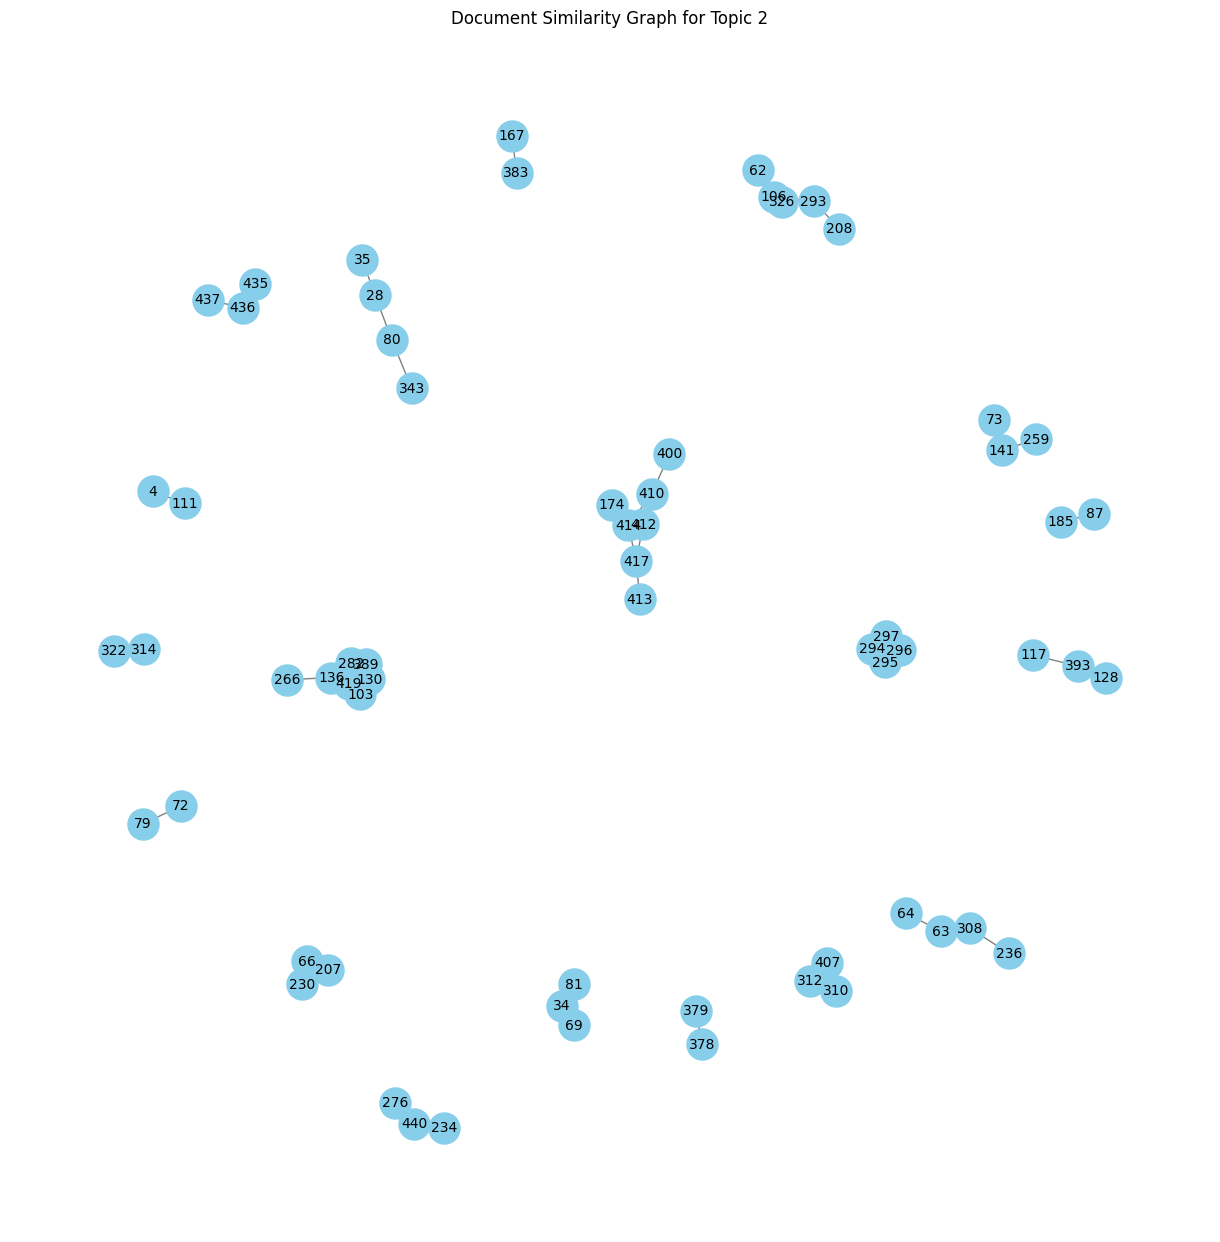

Documents related to Topic 3:

Document 1: Please report rule breaking posts, such as:

 - politics of any kind
 - discrimination, hate, or prejudice based on protected grounds
 - where the "funny" is mostly cringe, freakout, reaction, or cute
 - violence, injury, or animal abuse
 - pornography or sexually explicit material
 - threatening, advocating, wishing, or glorifying death or violence
 - contains graphic language or obvious mature themes, and is not marked NSFW

Please do not report content you simply don't like or disagree with. Abuse of the report button will be reported to Reddit and you may face account suspension.

###[Video Download](https://redditsave.com/info?url=https://v.redd.it/mmzjpgdyisb)

** All other video downloading comment tags will be removed **


*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/funnyvideos) if you have any questions or concerns.*

Document 2: He's not letting h

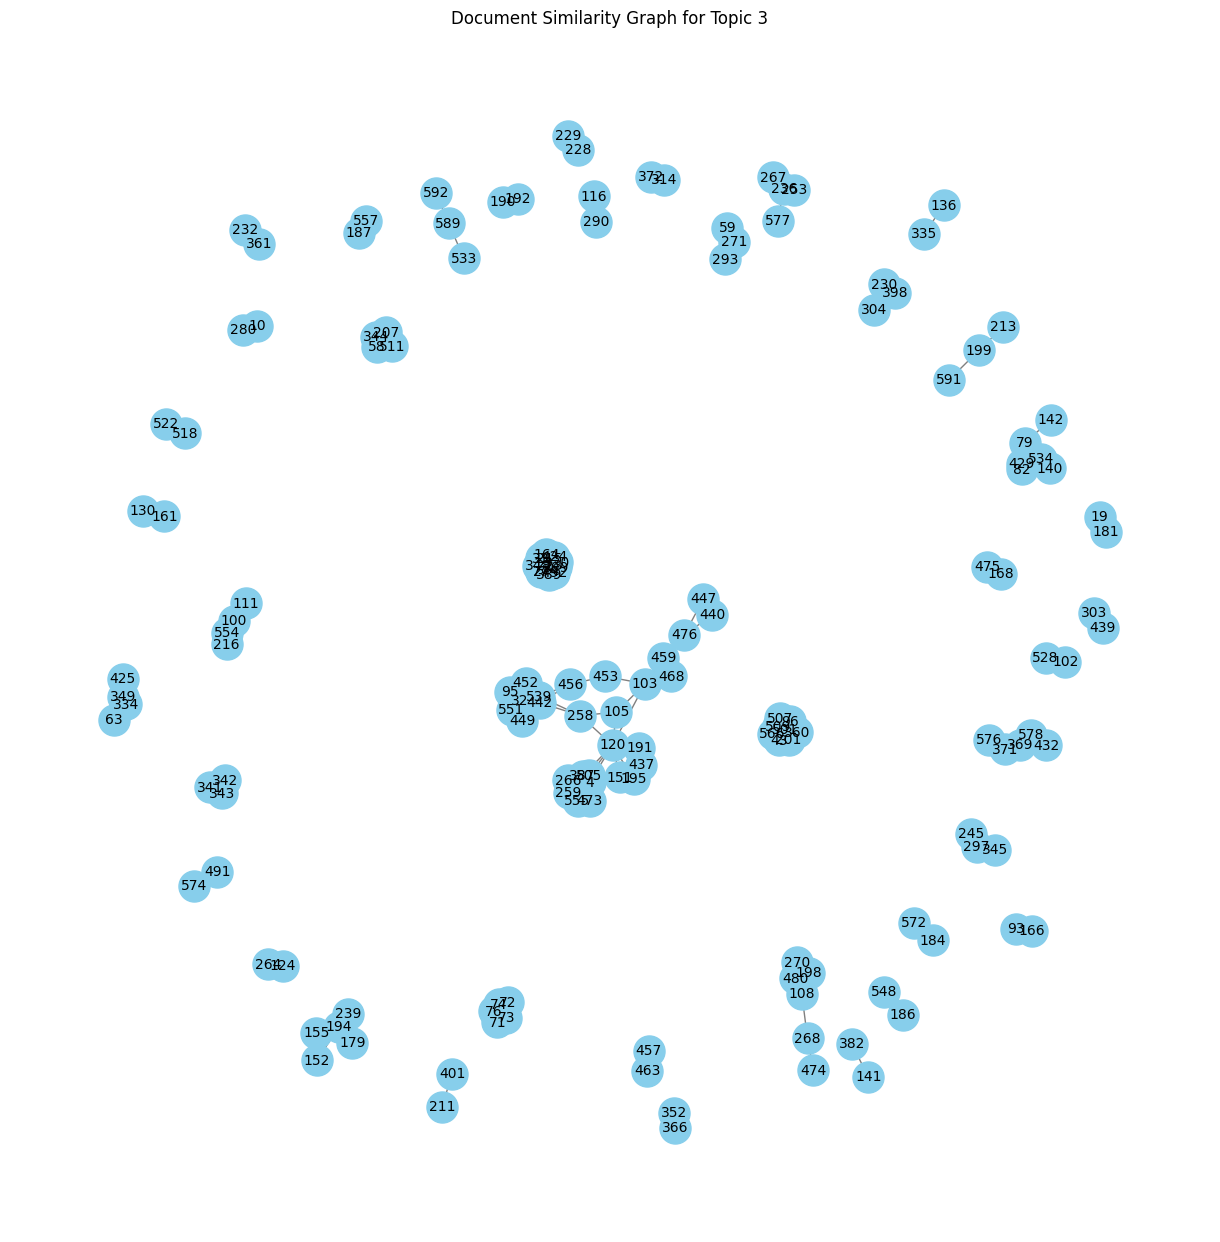

Documents related to Topic 4:

Document 1: David Beckham keeping it  percent real lol

Document 2: I remember my dad driving me to school in a used delta  with velvet interior and a really shitty radio.

For years I thought the song was "Secret asian man" because of that crap radio.

Document 3: I have to say this was a really good documentary - very interesting frankly about a subject I didn’t think I’d find interesting.  As an aside is there any top elite athlete who didn’t have abusive parental coaching?  It’

Document 4: She’s a fucking horrible person.

Document 5: She ruined the world cup for us , so stressed out  watching that lastnight . What an absolute bitch .

Document 6: Actually the other one marries a guy who operates a formula one team for a Austrian energy drink company. 

This one married a humble soccer(football) legend

Document 7: They try so hard to be some magical i defied all odds person. Cant have it all guys you already have more then most enjoy it with honoust

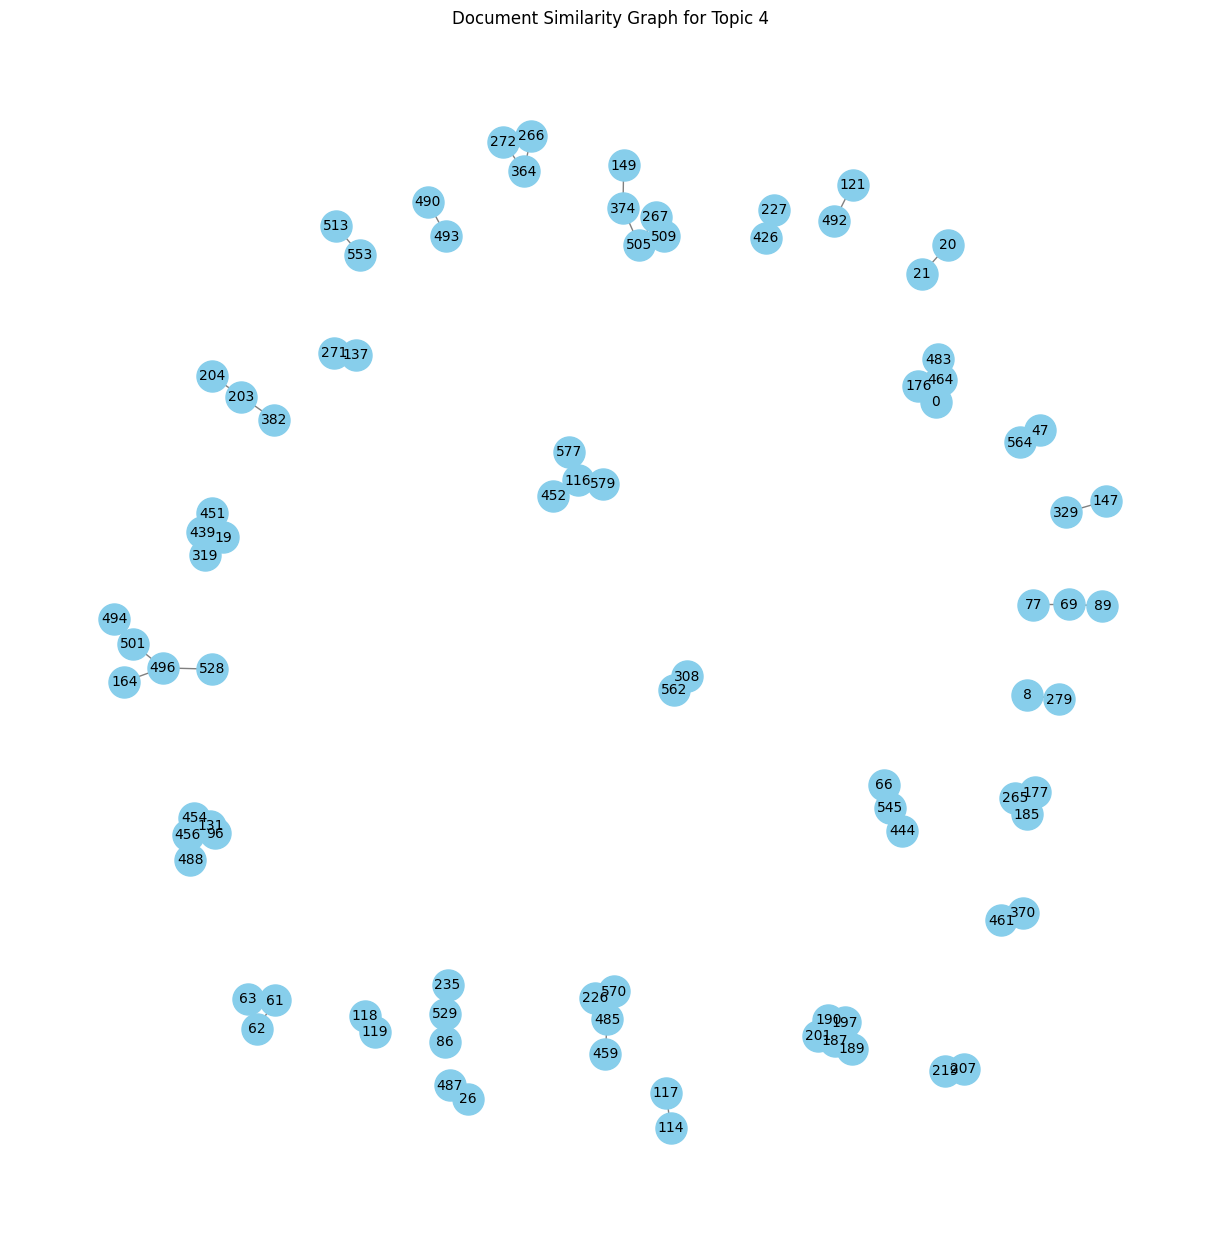

In [32]:
import networkx as nx
from networkx.algorithms import community
from sklearn.metrics.pairwise import cosine_similarity
# Define a threshold for considering a document as related to a topic
threshold = 0.7  # Example value, adjust as needed
doc_topic_dist = ldaModel.transform(tf)
# Iterate over each topic
for topic_idx in range(ldaModel.n_components): # Use n_components instead of num_topics
    # Extract documents related to the current topic
    related_docs_indices = np.where(doc_topic_dist[:, topic_idx] > threshold)[0]
    related_docs = [lPosts[i] for i in related_docs_indices]

    # Print the related documents
    print(f"Documents related to Topic {topic_idx}:\n")
    for idx, doc in enumerate(related_docs):
        print(f"Document {idx + 1}: {doc}\n")

    # Perform community analysis
    # Step 1: Vectorize the related documents using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(related_docs)

    # Step 2: Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)

    # Step 3: Create a graph from the cosine similarity matrix
    G = nx.Graph()
    for i in range(len(related_docs)):
        for j in range(i + 1, len(related_docs)):
            if cosine_sim_matrix[i, j] > 0.5:  # Example threshold, adjust as needed
                G.add_edge(i, j, weight=cosine_sim_matrix[i, j])

# Step 4: Detect communities using the Girvan-Newman method
    communities_generator = community.girvan_newman(G) # Call girvan_newman directly from the community module
    top_level_communities = next(communities_generator)
    sorted_communities = sorted(map(sorted, top_level_communities))

# Print the communities
    print(f"Communities for Topic {topic_idx}:\n")
    for idx, community_list in enumerate(sorted_communities): # Renamed 'community' to 'community_list' to avoid name conflict
        print(f"Community {idx + 1}:")
        for doc_idx in community_list:
            print(f"Document {doc_idx + 1}: {related_docs[doc_idx]}")
        print("="*80)  # Separator between communities

    # Export the graph to a GEXF file for Gephi
    nx.write_gexf(G, f"reddit_document_similarity_graph_topic_{topic_idx}.gexf")

    # Visualize the graph and save it as an image
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", edge_color="gray")
    plt.title(f"Document Similarity Graph for Topic {topic_idx}")
    plt.savefig(f"reddit_document_similarity_graph_topic_{topic_idx}.png")  # Save the graph as an image
    plt.show()